Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [ ]:
!pip install hydra-core --upgrade

In [ ]:
from src.commands import *
import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF = hydra_config("config1.yaml")
show_CONF(CONF)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.99,
                "pos_aug": 44,
                "neg_aug": 4
        },
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 20,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese",
                "path_log": "siamese.pickle"
        },
        "classifier": {
                "n_epochs": 10,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier",
                "path_log": "classifier.pickle"
        }
}


In [ ]:
show_CONF(CONF)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.99,
                "pos_aug": 44,
                "neg_aug": 4
        },
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 20,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese",
                "path_log": "siamese.pickle"
        },
        "classifier": {
                "n_epochs": 10,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier",
                "path_log": "classifier.pickle"
        }
}


# Библиотеки

In [ ]:
# from hydra import compose, initialize
# from omegaconf import OmegaConf

import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np
import random

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything, create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.classifier import get_predictions
from src.train import train, load_logs, load_model
from src.functions import confusion_matrix, distribution
from src.show_fun import show_result, show_images, plot_transformed_images

In [ ]:
def pos_neg_dataset(CONF):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    pos_dataset = My_Dataset(
        "pos",
        CONF.dataset.data_pos,
        augmentation=CONF.dataset.pos_aug,
        transform=transform,
        threshold=CONF.dataset.threshold,
        seed=CONF.seed,
        deterministic=True,
    )
    print(f"Positive dataset: {len(pos_dataset)}    ({pos_dataset.real_len})")

    neg_dataset = My_Dataset(
        "neg",
        CONF.dataset.data_neg,
        augmentation=CONF.dataset.neg_aug,
        transform=transform,
        threshold=CONF.dataset.threshold,
        seed=CONF.seed,
        deterministic=True,
    )
    print(f"Negative dataset: {len(neg_dataset)}    ({neg_dataset.real_len})")

    return pos_dataset, neg_dataset

In [ ]:
t = torch.tensor([[1, 2, 3, 4]])
print(f"{tuple(t.shape)}")

(1, 4)


In [ ]:
def plot_transformed_images(image_paths, transform, n=3):
    # https://www.learnpytorch.io/04_pytorch_custom_datasets/
    # random_image_paths = random.sample(image_paths, k=n)
    image_paths = image_paths[:n]

    for image_path in image_paths:

        f = Image.open(image_path)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {tuple(transformed_image.shape)}")
        ax[1].axis("off")

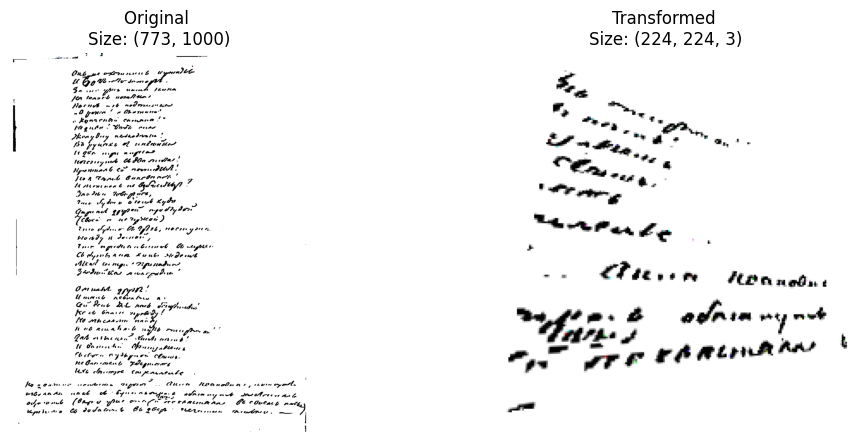

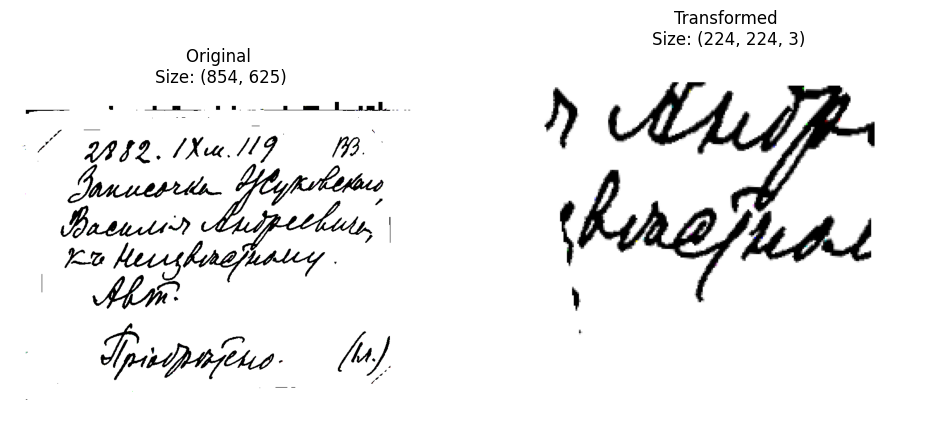

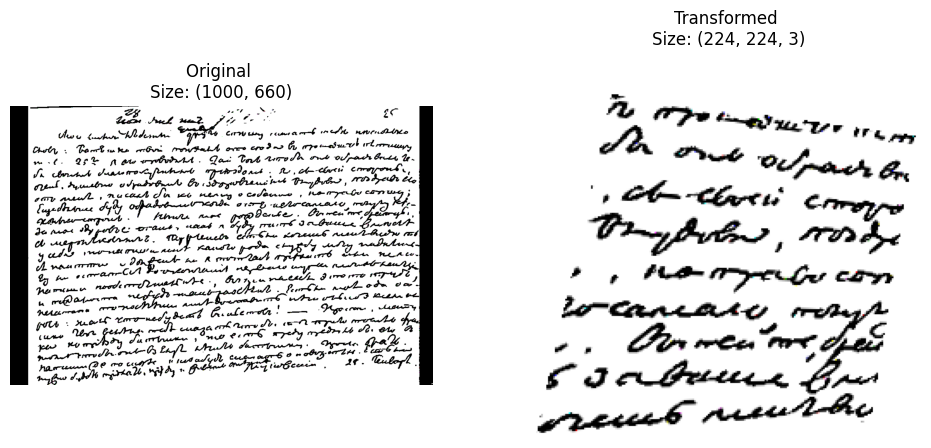

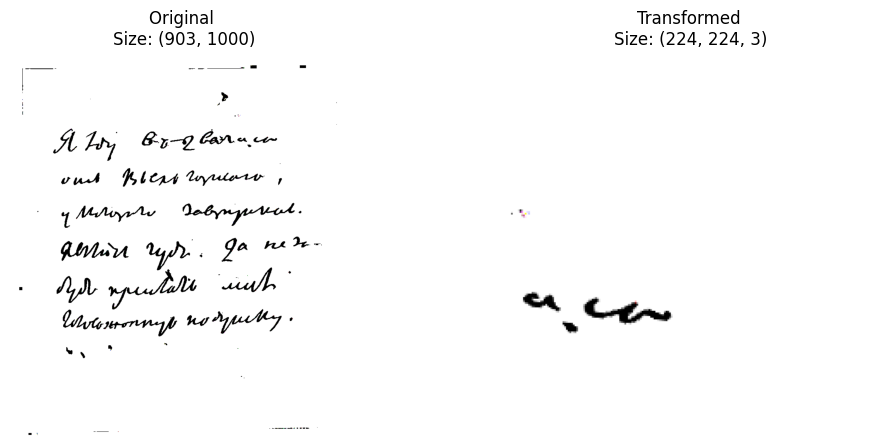

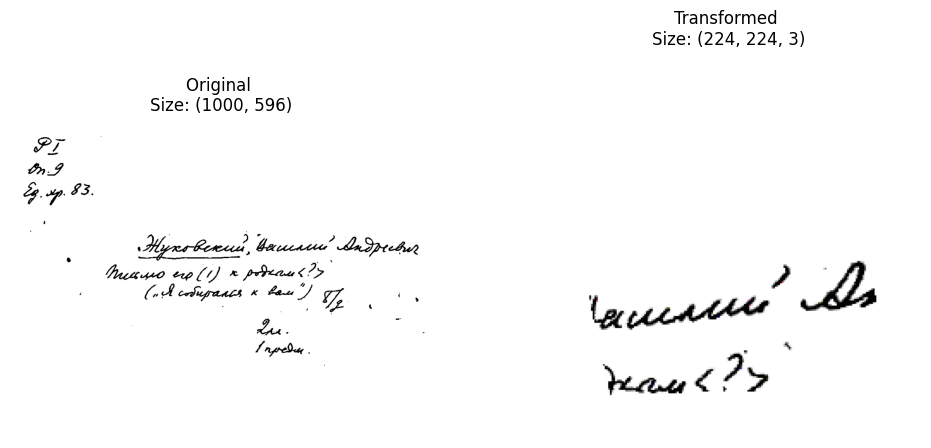

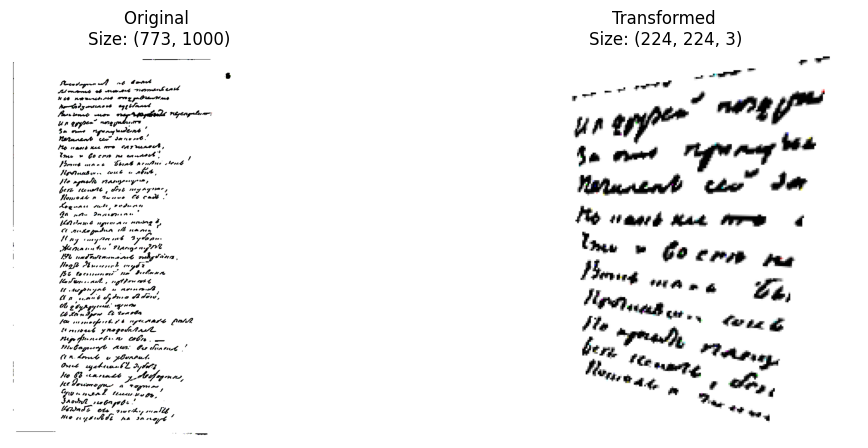

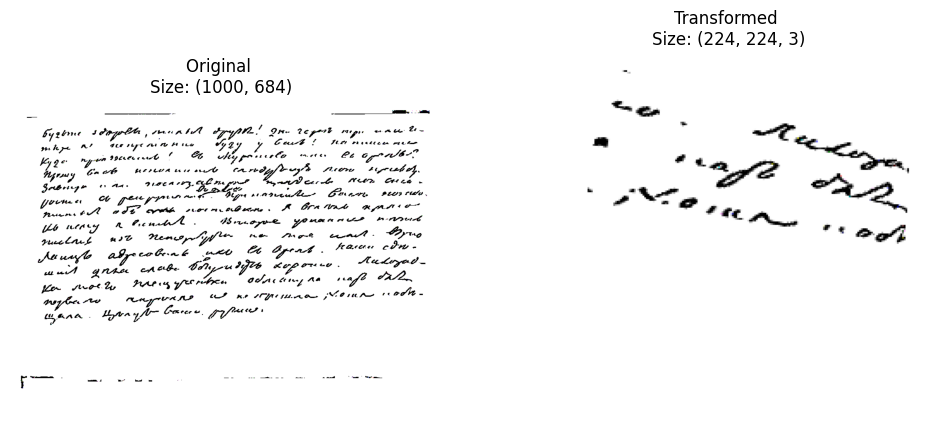

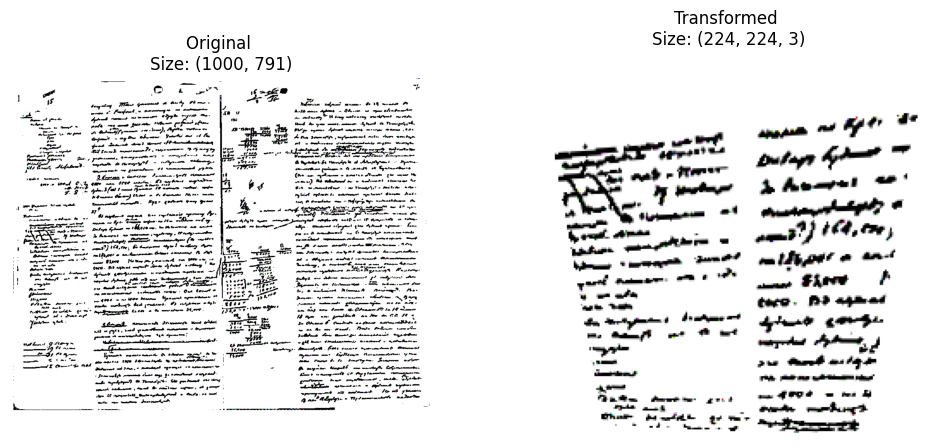

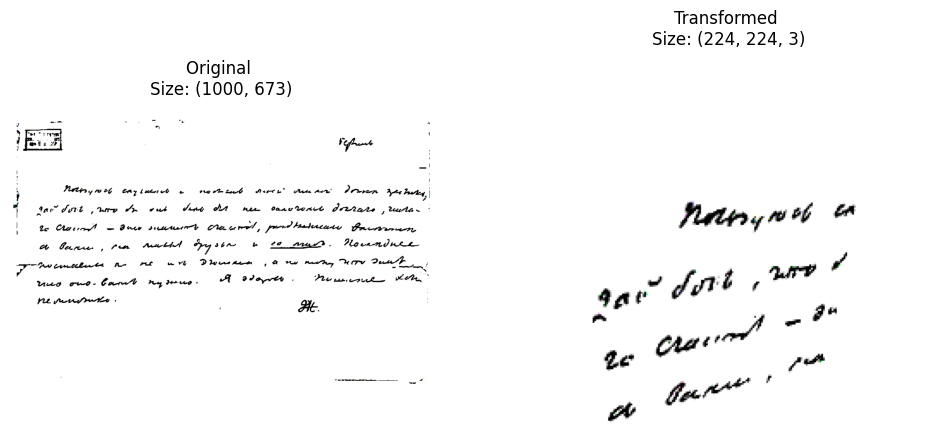

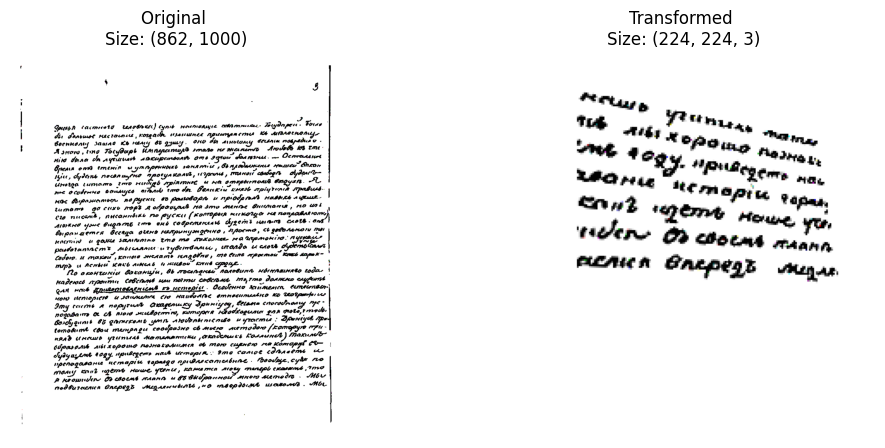

In [ ]:
transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )


files = os.listdir("bin/1")
files = [os.path.join("bin/1", i) for i in files]
plot_transformed_images(files, transform, n=10)

# train

[**TripletMarginLoss**
](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)

$L(a,p,n)=max\{d(ai​,pi​)−d(ai​,ni​) + margin,0\}$

$d(x_i, y_i) = \|x_i − y_i\|_p$

[Contrastive learning](https://www.v7labs.com/blog/contrastive-learning-guide#:~:text=Contrastive%20Learning%20is%20a%20technique,a%20data%20class%20from%20another.)

[Contrastive learning](https://colab.research.google.com/drive/1uvXs3P1XsH7Mtc20kEI2D9cAPcg-cjyw?usp=sharing#scrollTo=_mmDxSSu19_e)

[Cиамские сети](https://habr.com/ru/articles/794750/)

[Cиамские сети](https://habr.com/ru/companies/jetinfosystems/articles/465279/)



In [ ]:
pos_dataset, neg_dataset = pos_neg_dataset(CONF)

siam = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(CONF.device)
# load_best_model(CONF3, siam, train_dataset, test_dataset, kind="siam") #####

num_classes = 1000
num_non_freeze = 513000 # 11689512 # 513000
seed_everything(CONF.seed)
siam = create_model(siam, num_non_freeze, num_classes)
print(f"num parameters ResNet = {number_of_parameters(siam)}")

dataset1 = TripletDataset(
        pos_dataset, neg_dataset, required_len=10_000, deterministic=True, seed=CONF.seed
    )
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset1)

# common_train(CONF, siam, train_dataset, test_dataset, kind="siam")
load_best_model(CONF, siam, train_dataset, test_dataset, kind="siam")

Positive dataset: 968    (22)
Negative dataset: 896    (224)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.8MB/s]


num parameters ResNet = 513000
split_dataset: Train: 8000 Test: 2000 Total: 10000
load_best_model:
LOGS:
# 2024-05-30 11:59:50 Epoch 20 train/val: loss 0.05634/0.40875, acc: 99.963%/ 99.250%
MODEL:
# 2024-05-30 12:00:33 Epoch 20 train/val: loss 0.05634/0.40875, acc: 99.963%/ 99.250%


In [ ]:
logs = load_logs("checkpoints/siamese/siamese.pickle")
for i in range(len(logs["train_loss"])):
    params = (
            logs["time"][i],
            logs["epoch"][i],
            logs["train_loss"][i],
            logs["val_loss"][i],
            logs["train_accuracy"][i],
            logs["val_accuracy"][i],
        )
    log = f"# {{}} Epoch {{:{2}}} "
    log += f"train/val: loss {{:6.5f}}/{{:6.5f}}, acc:{{:7.3f}}%/{{:7.3f}}%"
    print(log.format(*params))

# 2024-05-30 10:47:45 Epoch  1 train/val: loss 2.29249/2.80796, acc: 93.463%/ 90.900%
# 2024-05-30 10:48:51 Epoch  2 train/val: loss 1.28180/1.86685, acc: 97.025%/ 94.400%
# 2024-05-30 10:49:57 Epoch  3 train/val: loss 0.76688/1.34580, acc: 98.763%/ 96.850%
# 2024-05-30 10:51:02 Epoch  4 train/val: loss 0.53949/1.11347, acc: 99.438%/ 97.450%
# 2024-05-30 10:52:07 Epoch  5 train/val: loss 0.38314/0.91758, acc: 99.612%/ 98.100%
# 2024-05-30 10:53:12 Epoch  6 train/val: loss 0.30419/0.80158, acc: 99.763%/ 98.450%
# 2024-05-30 10:54:16 Epoch  7 train/val: loss 0.22415/0.70490, acc: 99.875%/ 98.400%
# 2024-05-30 10:55:22 Epoch  8 train/val: loss 0.17857/0.64127, acc: 99.938%/ 98.950%
# 2024-05-30 10:56:26 Epoch  9 train/val: loss 0.16026/0.63594, acc: 99.950%/ 98.650%
# 2024-05-30 10:57:31 Epoch 10 train/val: loss 0.14800/0.61174, acc: 99.963%/ 98.750%
# 2024-05-30 10:58:36 Epoch 11 train/val: loss 0.13363/0.57080, acc: 99.975%/ 98.750%
# 2024-05-30 10:59:49 Epoch 12 train/val: loss 0.11735

In [ ]:
cl = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 2)).to(
    CONF.device
)
num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
dataset2 = Emb_Dataset(siam, dataset, CONF.device)
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset2)

common_train(CONF, cl, train_dataset, test_dataset, kind="cl")
load_best_model(CONF, cl, train_dataset, test_dataset, kind="cl")

num parameters = 513538
split_dataset: Train: 1491 Test: 373 Total: 1864
train: started, kind = 'cl'
# 2024-05-30 12:00:46 Epoch  1 train/val: loss 0.41579/0.46245, acc: 86.318%/ 80.429%
# 2024-05-30 12:00:58 Epoch  2 train/val: loss 0.33458/0.38048, acc: 91.751%/ 86.595%
# 2024-05-30 12:01:08 Epoch  3 train/val: loss 0.28296/0.34342, acc: 92.824%/ 88.472%
# 2024-05-30 12:01:19 Epoch  4 train/val: loss 0.24630/0.30760, acc: 95.037%/ 90.349%
# 2024-05-30 12:01:30 Epoch  5 train/val: loss 0.21667/0.29753, acc: 94.769%/ 89.812%
# 2024-05-30 12:01:42 Epoch  6 train/val: loss 0.19015/0.26285, acc: 96.445%/ 91.421%
# 2024-05-30 12:01:53 Epoch  7 train/val: loss 0.16784/0.25575, acc: 96.647%/ 91.153%
# 2024-05-30 12:02:04 Epoch  8 train/val: loss 0.15155/0.24050, acc: 97.854%/ 91.421%
# 2024-05-30 12:02:14 Epoch  9 train/val: loss 0.13873/0.24789, acc: 97.049%/ 91.421%
# 2024-05-30 12:02:25 Epoch 10 train/val: loss 0.12359/0.21888, acc: 98.457%/ 92.493%
# Время работы: 00:01:52
load_best_mode

In [ ]:
def graph2(x, y1, y2, title="", ylog=True):
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=13)

    plt.plot(x, y1, color='g', label = "Train")
    plt.plot(x, y2, color='m', label = "Test")

    plt.grid(True)
    plt.ylabel("loss",  fontsize=10)
    plt.xlabel("Номер итерации",  fontsize=10)

    if ylog:
        plt.yscale('log')

    plt.legend(fontsize=10)

    plt.show()

In [ ]:
# graph2(logs['epoch'], logs['train_loss'], logs['val_loss'], title="")

In [ ]:
# graph2(logs['epoch'], logs['train_accuracy'], logs['val_accuracy'], ylog = False)

# eval

In [ ]:
class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x.to(CONF.device))
        x = self.cl(x)
        return x

model = Pipeline(siam, cl)

0.987603305785124


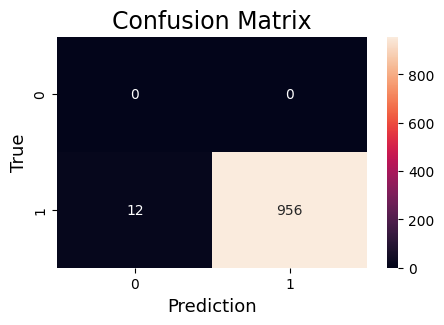

[[  0   0]
 [ 12 956]]


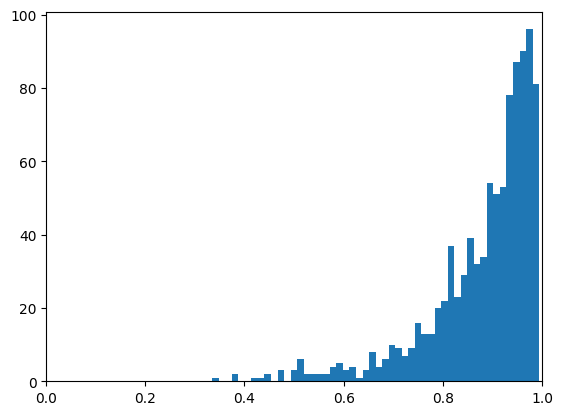

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.987603305785124
# array([[  0,   0],
#        [  6, 478]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9564732142857143


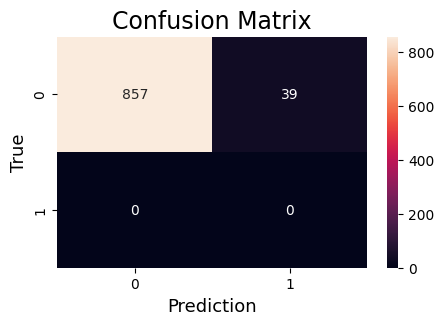

[[857  39]
 [  0   0]]


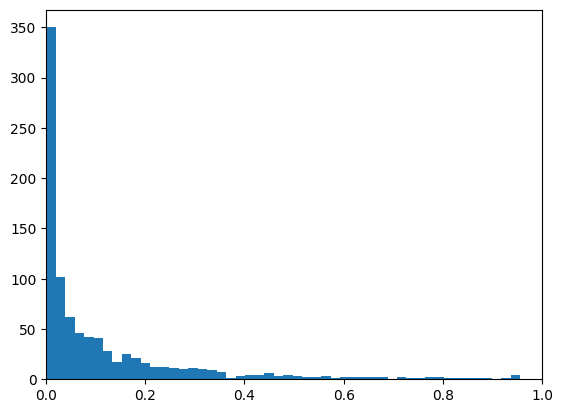

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.96875
# array([[435,  13],
#        [  0,   0]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9726394849785408


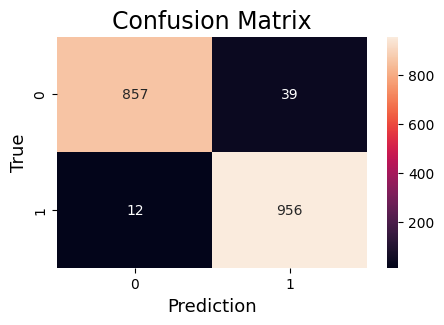

[[857  39]
 [ 12 956]]


In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
print(confusion_matrix(y_true, y_pred))
# 0.9785407725321889
# array([[435,  13],
#        [  6, 478]])

# eval (без аугментации)

In [ ]:
def pos_neg_dataset(CONF):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    pos_dataset = My_Dataset(
        "pos",
        CONF.dataset.data_pos,
        augmentation=CONF.dataset.pos_aug,
        transform=transform,
        threshold=CONF.dataset.threshold,
        seed=CONF.seed,
        deterministic=True,
    )
    print(f"Positive dataset: {len(pos_dataset)}    ({pos_dataset.real_len})")

    neg_dataset = My_Dataset(
        "neg",
        CONF.dataset.data_neg,
        augmentation=CONF.dataset.neg_aug,
        transform=transform,
        threshold=CONF.dataset.threshold,
        seed=CONF.seed,
        deterministic=True,
    )
    print(f"Negative dataset: {len(neg_dataset)}    ({neg_dataset.real_len})")

    return pos_dataset, neg_dataset

In [ ]:
CONF.dataset.pos_aug = 3
CONF.dataset.neg_aug = 1

In [ ]:
pos_dataset, neg_dataset = pos_neg_dataset(CONF)

Positive dataset: 66    (22)
Negative dataset: 224    (224)


0.8484848484848485


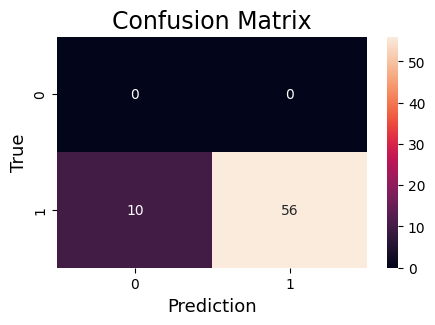

[[ 0  0]
 [10 56]]


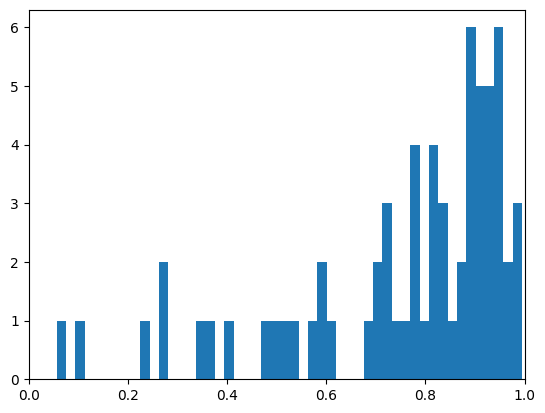

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.987603305785124
# array([[  0,   0],
#        [  6, 478]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.8616071428571429


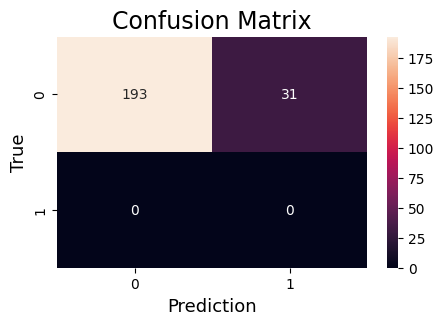

[[193  31]
 [  0   0]]


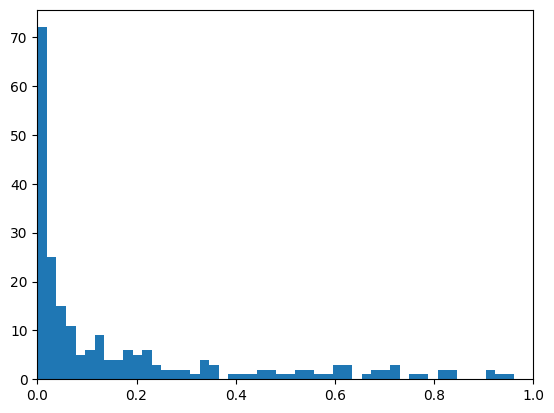

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.96875
# array([[435,  13],
#        [  0,   0]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

# show

prob < 0.5
count : 10 out of 66
pic idx : [59, 55, 2, 22, 58, 26, 18, 46, 14, 15]


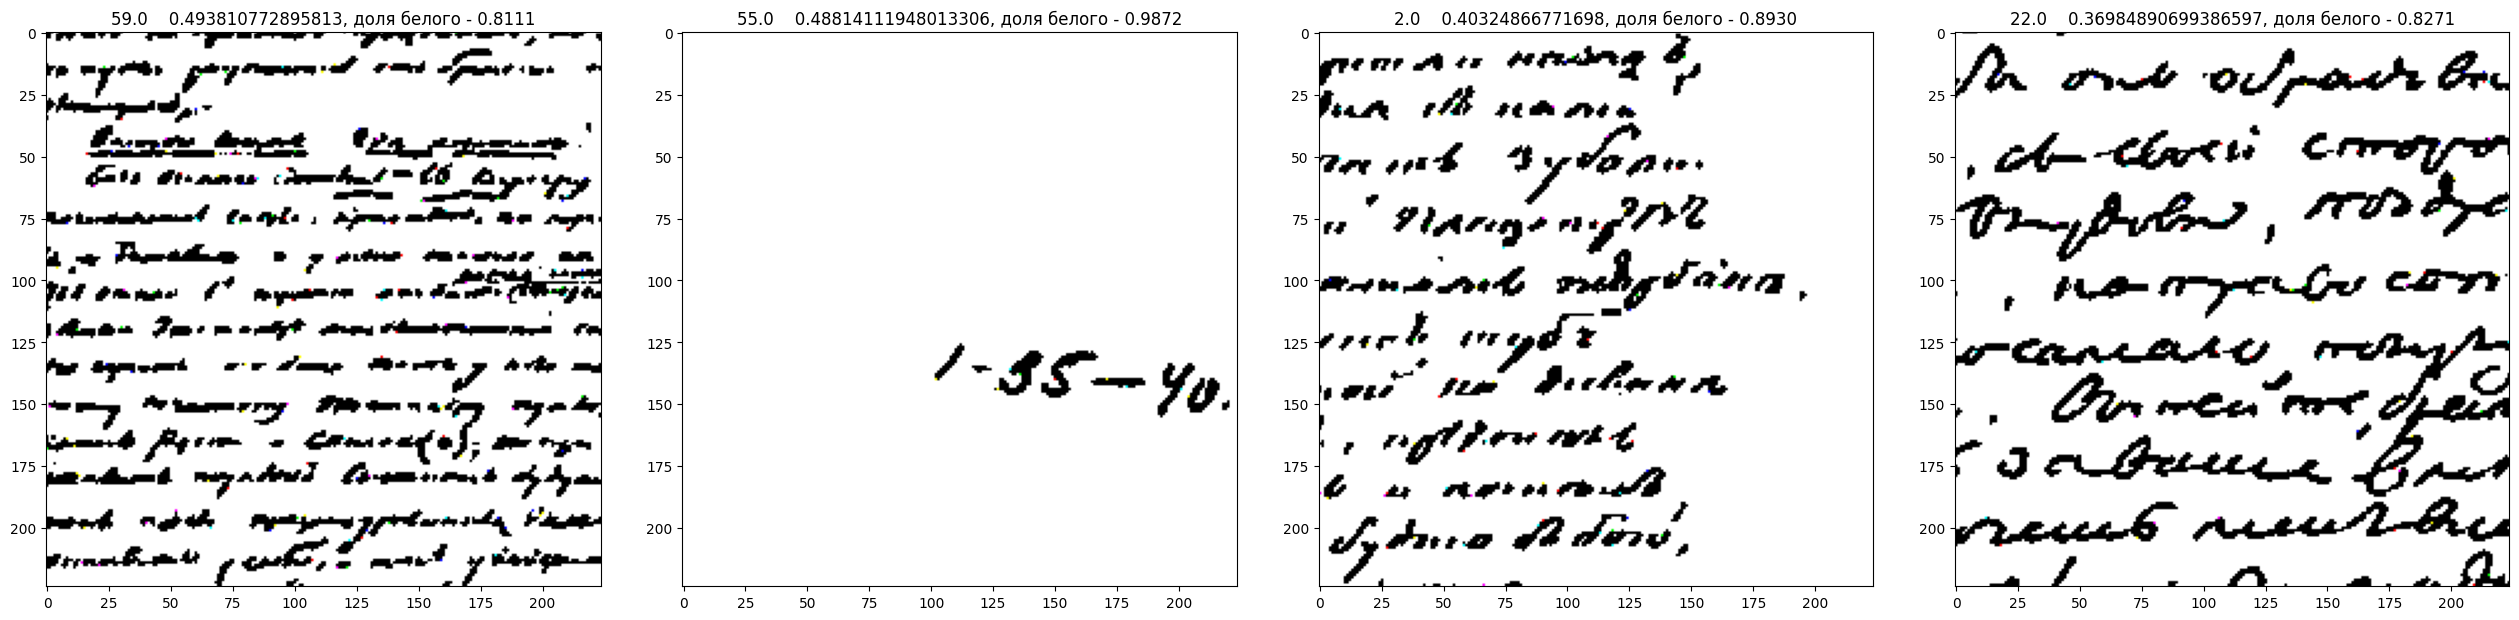

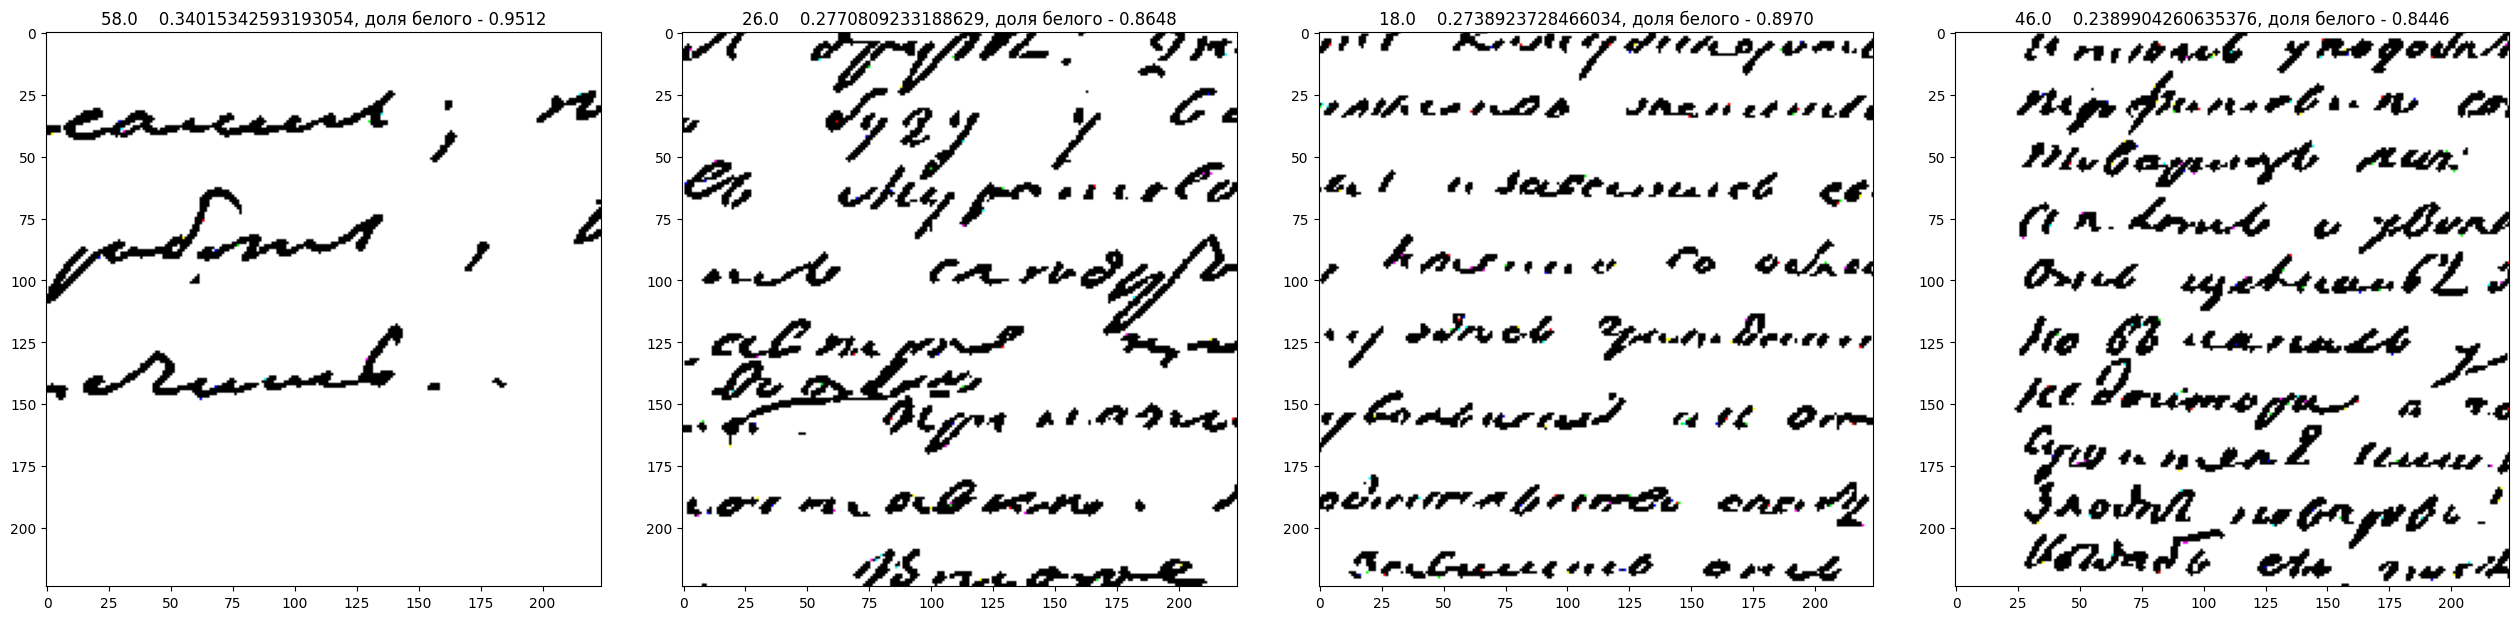

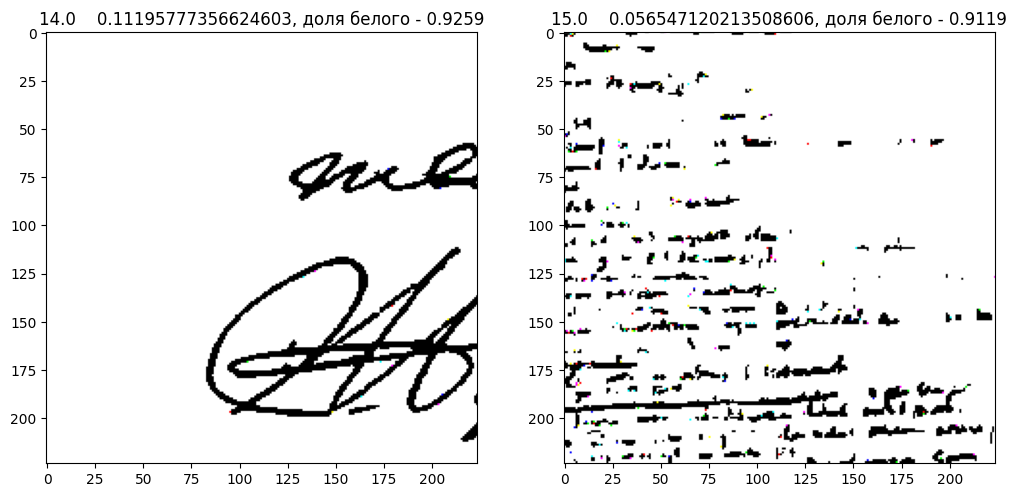

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.5,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 30,
                                   sort = True)

prob > 0.4
count : 38 out of 224
pic idx : [131, 202, 46, 154, 13, 206, 64, 210, 211, 128, 32, 195, 205, 26, 113, 137, 38, 130, 152, 222, 111, 62, 179, 204]


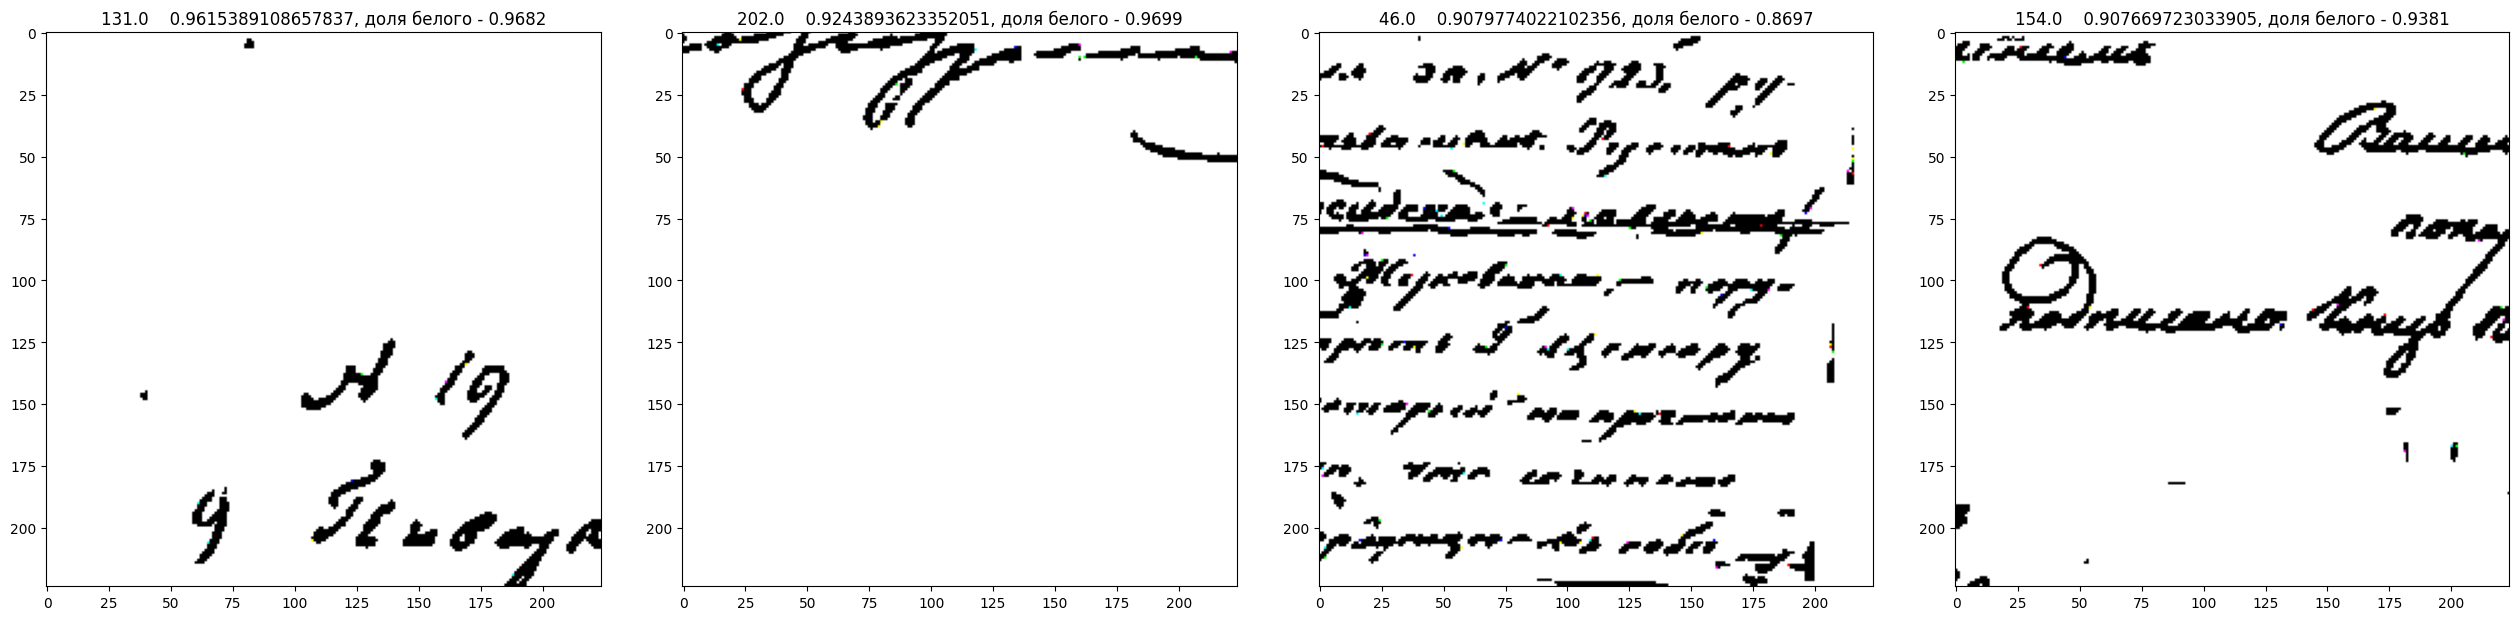

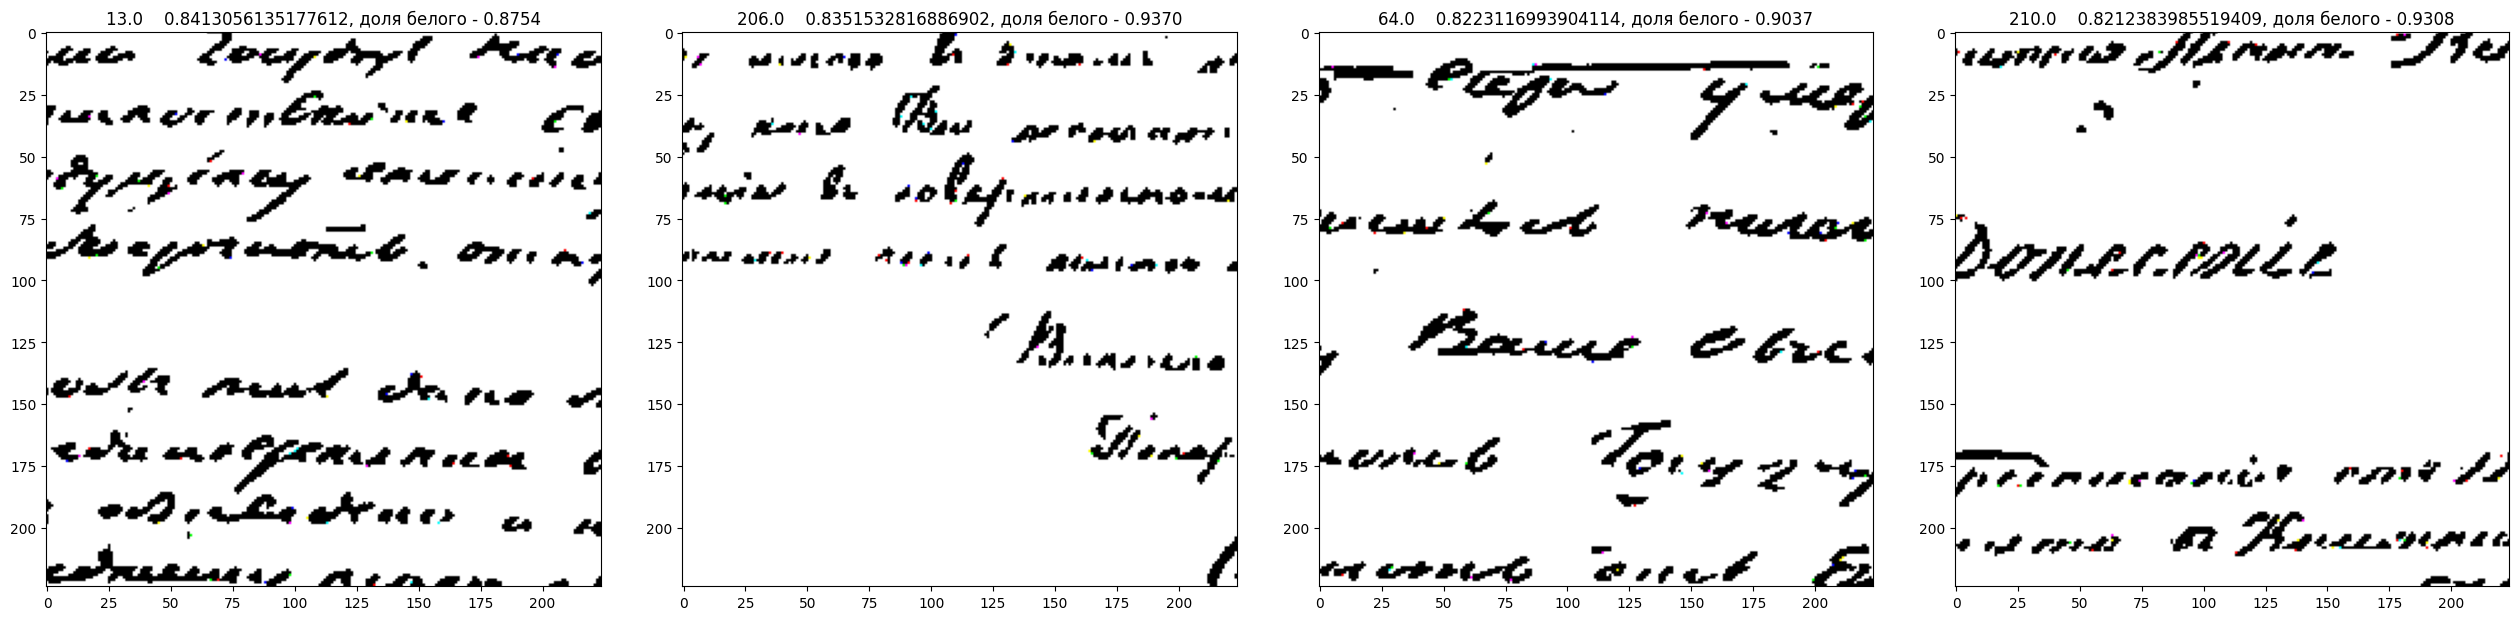

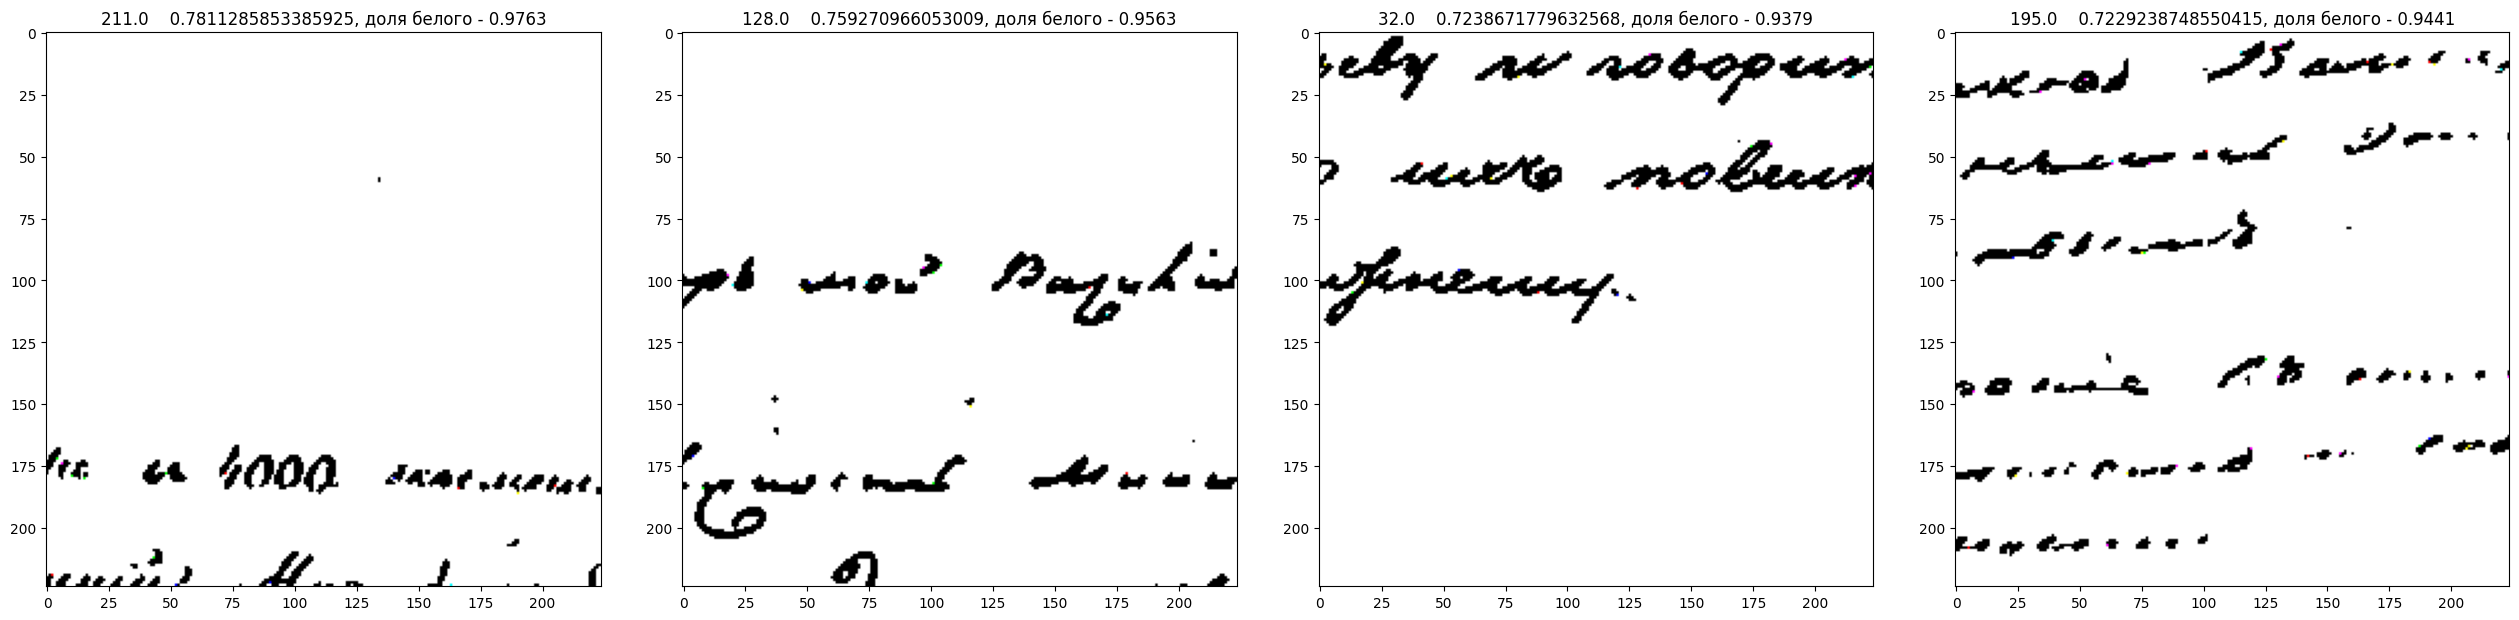

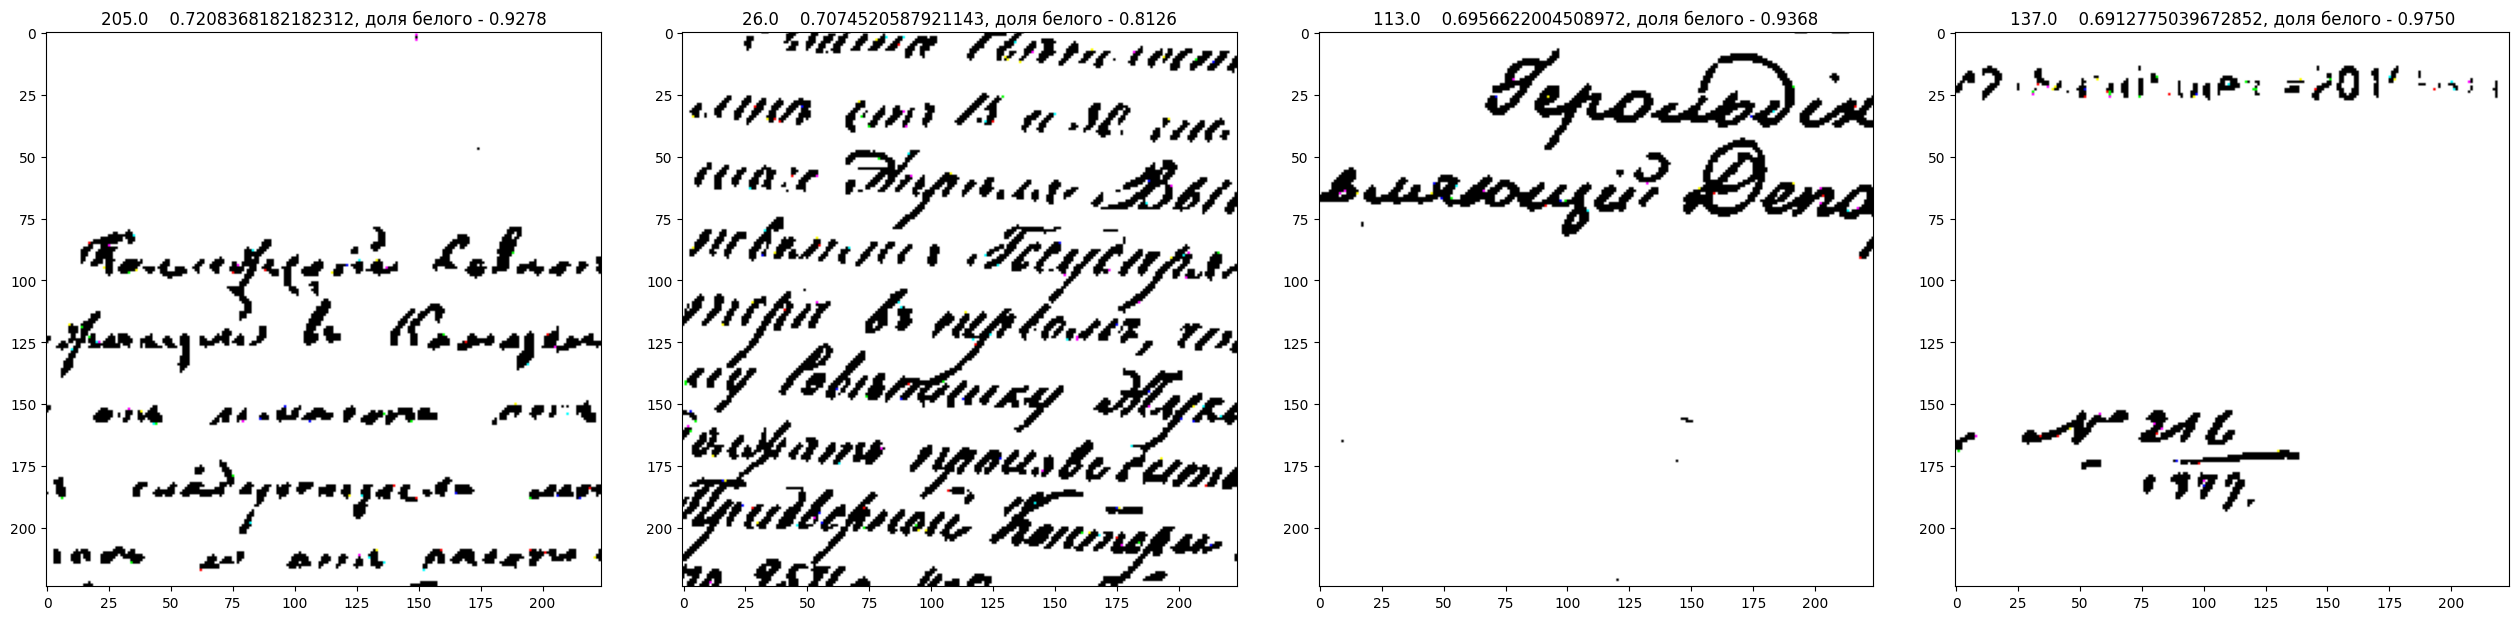

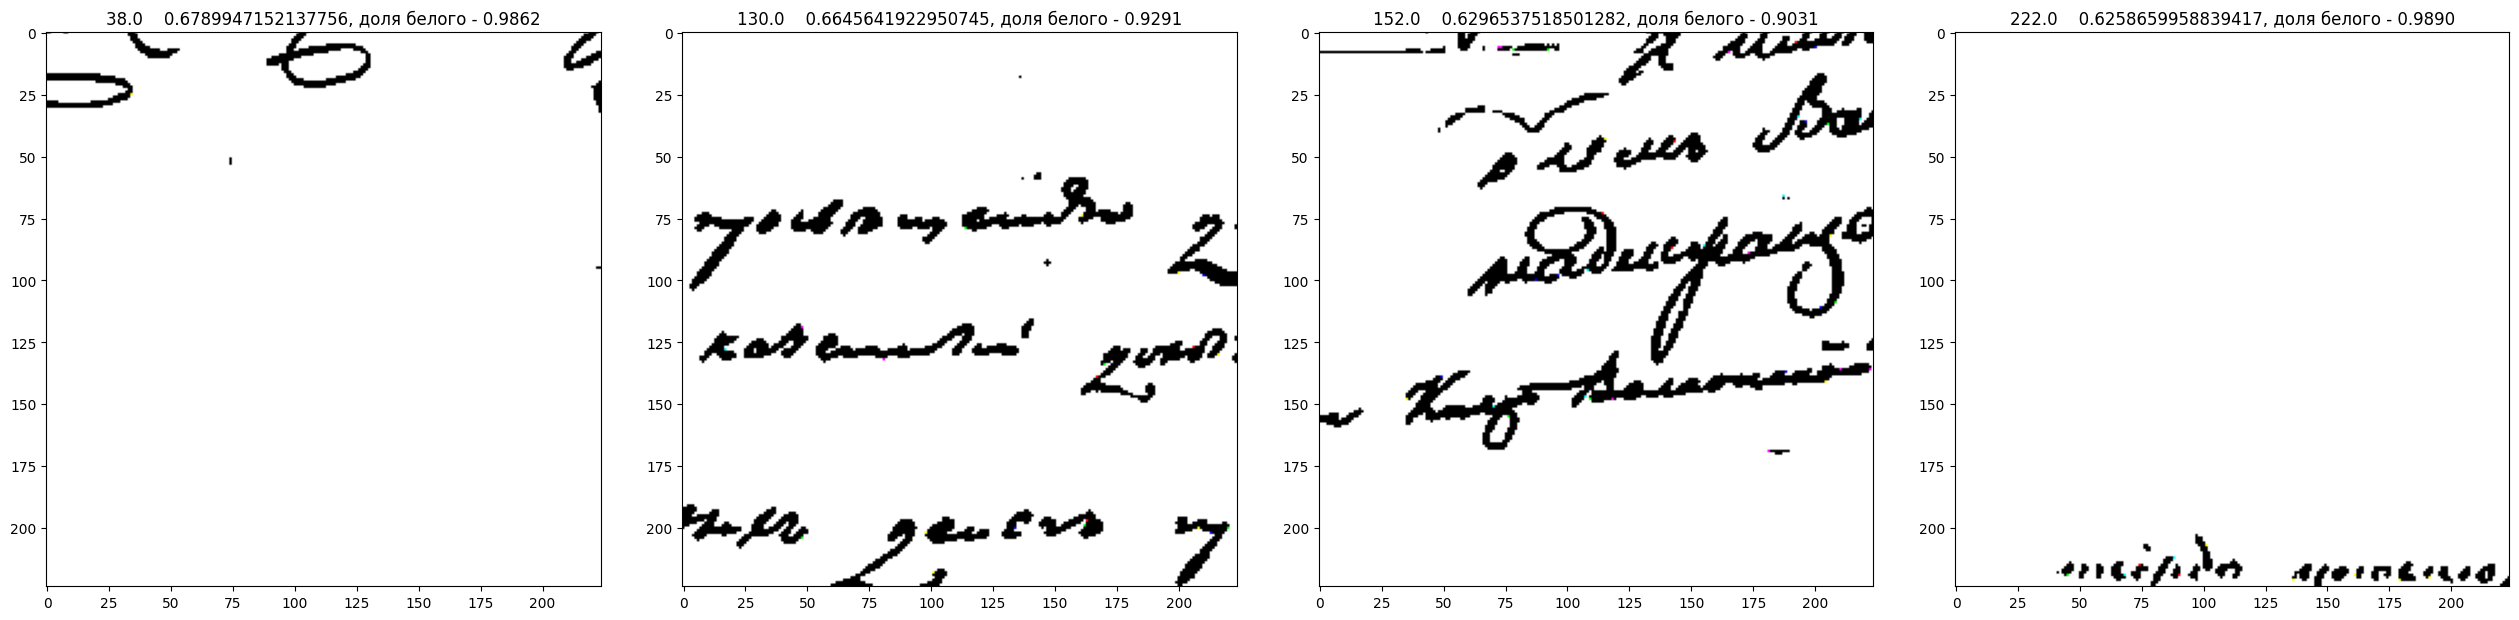

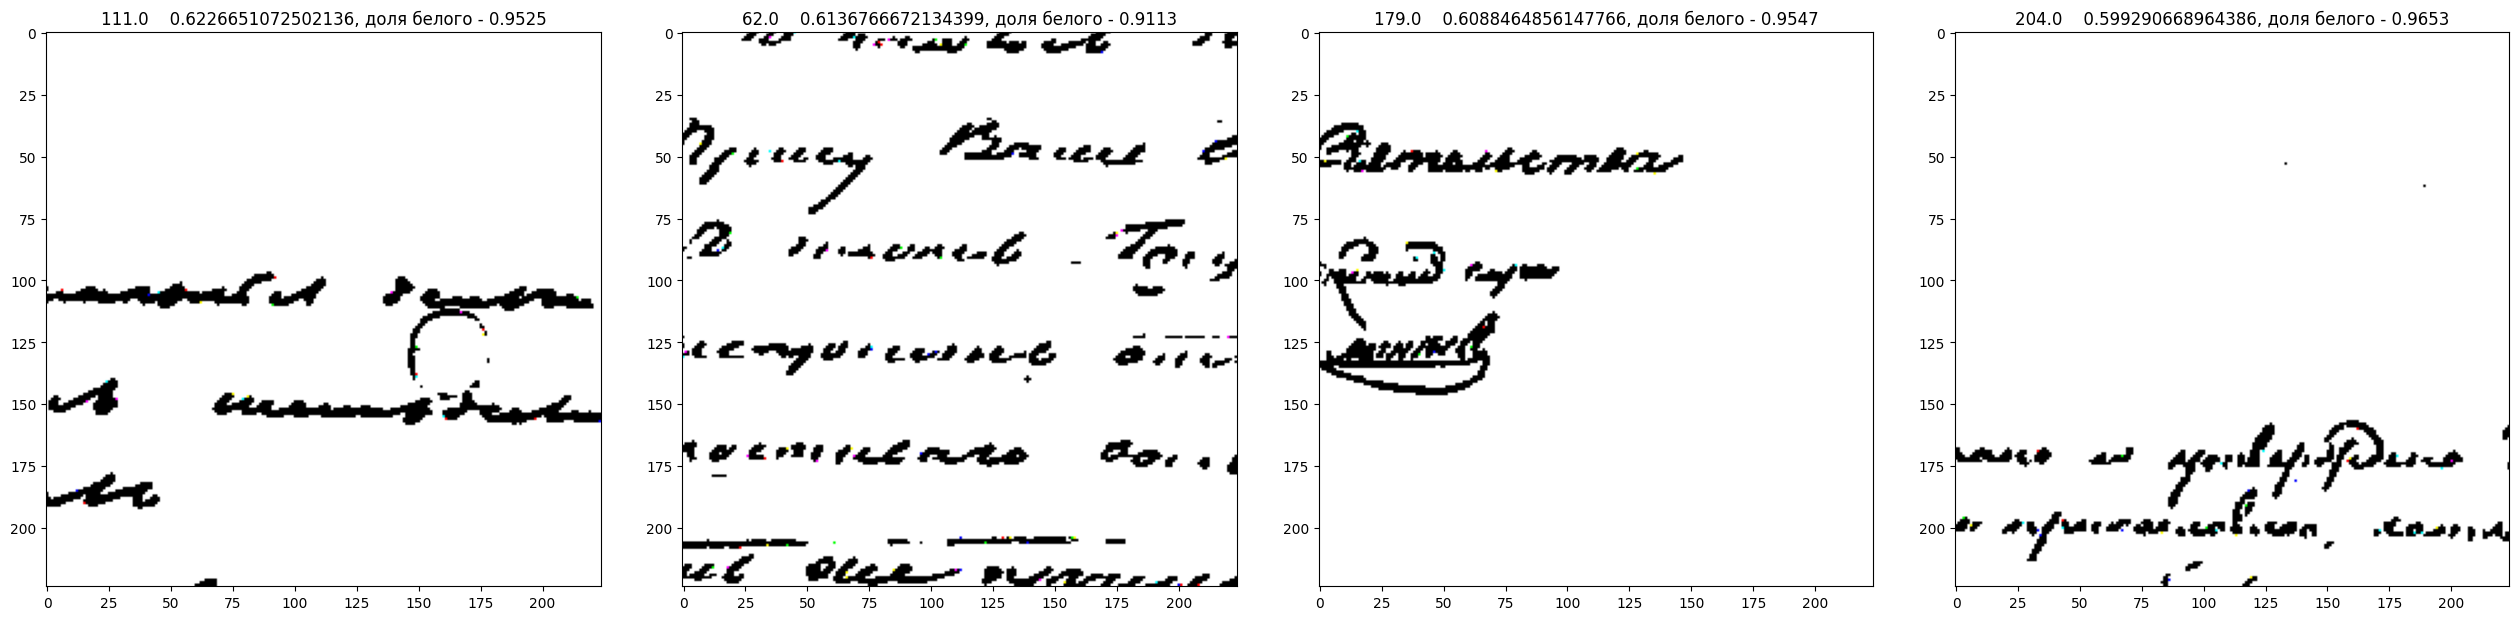

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.4,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 24,
                                   sort = True)

# on the entire dataset

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 448,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 484,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.